In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pmaw import PushshiftAPI
import matplotlib.pyplot as plt
import math
from datetime import datetime
import datetime as dt
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import re
import string
import seaborn as sns
from wordcloud import WordCloud

import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
pd.set_option('display.max_colwidth', -1)
import pandas_market_calendars as mcal
from sklearn.preprocessing import MinMaxScaler

<ipython-input-1-5c526b44d1c2>:40: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
df = pd.read_csv('data/amc_modeling.csv', low_memory=False)

In [3]:
df.dropna(inplace=True)

In [4]:
X = df['cleaned_body']
y = df['new_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
stopwords_list = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stopwords_list, max_features=200)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Categorical Classification

### First Simple Model: NaiveBayes

In [6]:
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized, y_train)
baseline_model.score(X_train_vectorized, y_train)

0.7168636879716823

In [7]:
y_pred_bm = baseline_model.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_bm))

0.7166212534059946


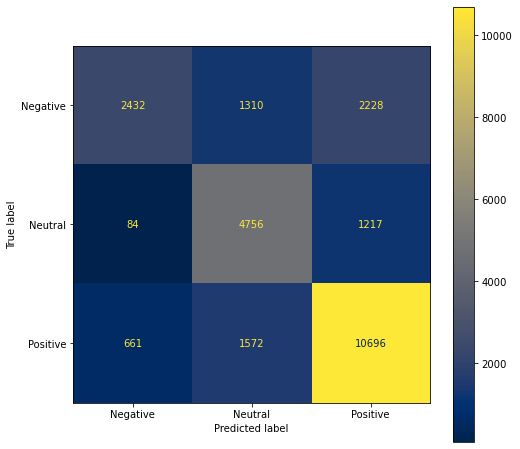

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(baseline_model, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### RandomForest

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
rf.score(X_train_vectorized, y_train)

0.9108662258732385

In [10]:
y_pred_rf = rf.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_rf))

0.7324891809584869


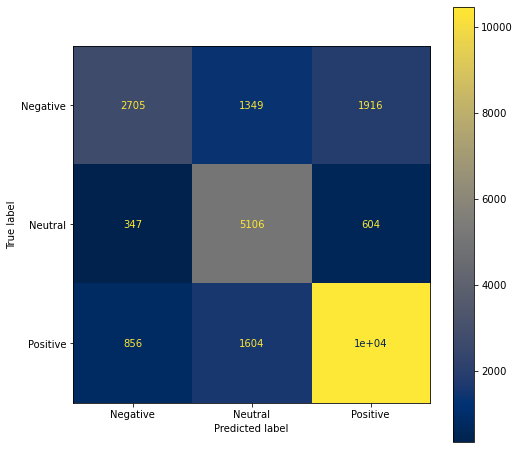

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(rf, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### DecisionTree

In [12]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vectorized, y_train)
dt.score(X_train_vectorized, y_train)

0.9108662258732385

In [13]:
y_pred_dt = dt.predict(X_test_vectorized)
y_pred_dt = dt.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_dt))

0.6885318159961532


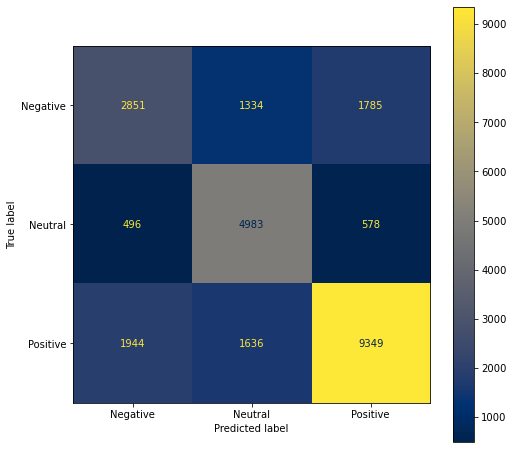

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(dt, X_test_vectorized, y_test, ax=ax, cmap="cividis");

### XGBoost

In [15]:
from xgboost import XGBClassifier

In [16]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train_vectorized, y_train)
xgb.score(X_train_vectorized, y_train)

C:\Users\dougl\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7755025712949977

In [17]:
y_pred_xgb = xgb.predict(X_test_vectorized)
print(accuracy_score(y_test, y_pred_xgb))

0.7465539349254688


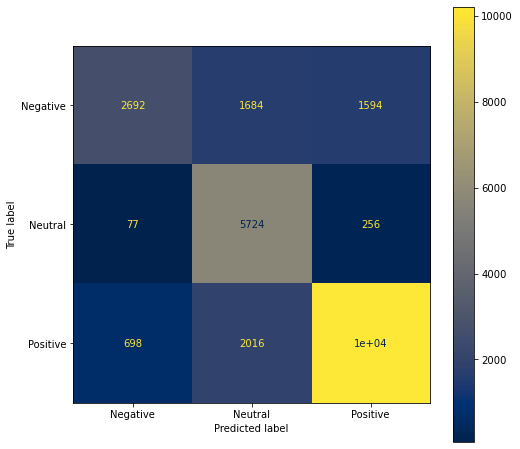

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(xgb, X_test_vectorized, y_test, ax=ax, cmap="cividis");

The XGBoost did the best with a 77.6% training accuracy score and 74.7% test accuracy score. The naive bayes was a good first simple model. The training and test scores were similar at ~71.6%. The decision tree and random forest had overfitting resulting in lower test scores than training scores. 

### Verifying the accuracy of the body_sentiment column by manual labeling

Create a random sample of 100 entries. Manually label the comments either positive, neutral, or negative. Verify the accuracy of body_sentiment generated by VADER. 
Create a new column called blob_sent generated by another lexicon sentiment analyzer, TextBlob (SentiWordNet). 
<br><br>
The first modeling csv distribution according to VADER was Positive 40%, Neutral 34%, Negative 26%. The corresponding distribution according to TextBlob was Neutral 39%, Positive 37%, Negative 24%.
<br><br>
The second modeling data had a 50% positive, 25% neutral, 25% negative distribution in VADER with added words. It had a 44% neutral, 33% positive, 23% negative distribution in TextBlob default settings.

In [2]:
df = pd.read_csv('data/amc_modeling.csv', low_memory=False)

In [8]:
sample_df = df.sample(n=1000, random_state=42)

In [10]:
sample_df.iloc[0:20]['body']

75721    Its a good strategy I averaged it down from $292 to $157 and then was that's enough.  I got it down to a point where I think I can break even make a little profit (I still think it has close to $200 potential I just know how much fuckery the hedgies are willing to do to keep it low so my more realistic hope is $125). Its now become a long play for me too, I got other plays too, I only invested what I could afford to lose.  Tomorrow I look for some new plays, Id also like to get out of amc sitting at $10 a share there.  NOK I bought as a long play I am ok there at about $5 a share, but I like them from DD and how much they seem to spearheading 5g.
80184    Personally I think amc is a way way worse play than gme                                                                                                                                                                                                                                                                                

In [22]:
labels = []

In [23]:
# sample_df = sample_df[['body','cleaned_body','body_sentiment','blob_sent']]
sample_df = sample_df[['body','cleaned_body','new_sentiment']]

In [24]:
sample_df['labels']=labels

In [25]:
sample_df['labels'].value_counts()

Positive    50
Neutral     26
Negative    24
Name: labels, dtype: int64

In [26]:
accuracy_score(sample_df['labels'],sample_df['new_sentiment'])

0.42

VADER is returning a ~43% accuracy score on it's rule based sentiment classifications as compared to my manually labeled column. When I performed the accuracy score on TextBlob sentiment classifications against the manually labeled column, it turned out to be similar but worse at 35% accuracy. It may be due to the subjective nature of posts in relation to the stock market and price, as well as the amount of noise present within reddit and social media environments in general. The only way to seemingly overcome this is to manually label and train the model.
<br><br>
Let's try quantitative analysis of the sentiment scores in the next section and see how these scores changed over time. We will import the time series data we prepared in the EDA as well as AMC YTD price data. 

# Time Series (numerical classification)

In [4]:
ts = pd.read_csv('data/amc_numeric_sents.csv', low_memory=False)
ts.head()

,cleaned_body,created_utc,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment
0,love movies movies really seen theater really appreciate im definitely hitting amc watch flicks beer tendies,1614904519,0.439001,0.561001,0.000001,0.879501
1,question anyone answer hedgefunds shorted gme hedgefunds shorted amc two similar price action,1614904484,0.000001,1.000001,0.000001,0.000001
2,hey guys scale 110 retarded bought 7 puts amc tanking 50 everything ive earned 9,1614904447,0.000001,0.764001,0.236001,-0.571899
3,got 50 amc 1330 52 gme 111 don’t forget way,1614904423,0.000001,0.826001,0.174001,-0.226299
4,truly fuck amc,1614904404,0.392001,0.135001,0.473001,-0.153099


In [5]:
price = pd.read_csv('data/ytd_prices_AMC.csv')
price['Date'] = pd.to_datetime(price['Date'])
price.set_index('Date',inplace=True)

In [6]:
date = []
for i in ts['created_utc']:
    x = int(i)
    date.append(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
ts['date']=date
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date',inplace=True)

In [7]:
ts.drop(['cleaned_body','created_utc','Neutral Sentiment','Negative Sentiment','Compound Sentiment'],axis=1,inplace=True)

In [8]:
ts_d = ts.resample('D').mean()
ts_d = ts_d.interpolate()

In [9]:
nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date='2021-01-01', end_date='2021-11-20')
ts_d = ts_d[ts_d.index.isin(early.index)==True]

In [10]:
prices = price[['Close']]

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ts_d)
normalized = scaler.transform(ts_d)
my_list = map(lambda x: x[0], normalized)
ts_d_normalized = pd.Series(my_list)
price_scaler = scaler.fit(prices)
price_normalized = price_scaler.transform(prices)
price_list = map(lambda x: x[0], price_normalized)
price_d_normalized = pd.Series(price_list)

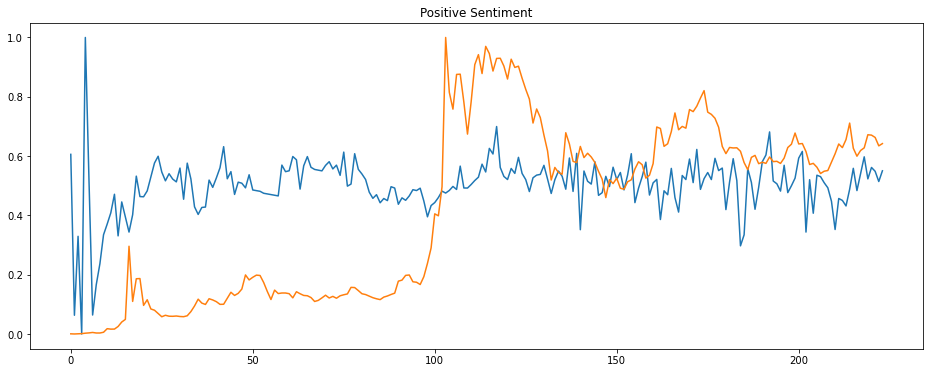

In [12]:
plt.figure(figsize=(16,6))
ts_d_normalized.plot()
price_d_normalized.plot()
plt.title('Positive Sentiment');

In [13]:
adfuller(ts_d['Positive Sentiment'])

(-6.3751399015812815,
 2.2936541161713722e-08,
 3,
 220,
 {'1%': -3.4604283689894815,
  '5%': -2.874768966942149,
  '10%': -2.57382076446281},
 -1163.9123818598828)

Both the daily and weekly positive sentiments meet the criteria for stationarity according to the dicky fuller test.

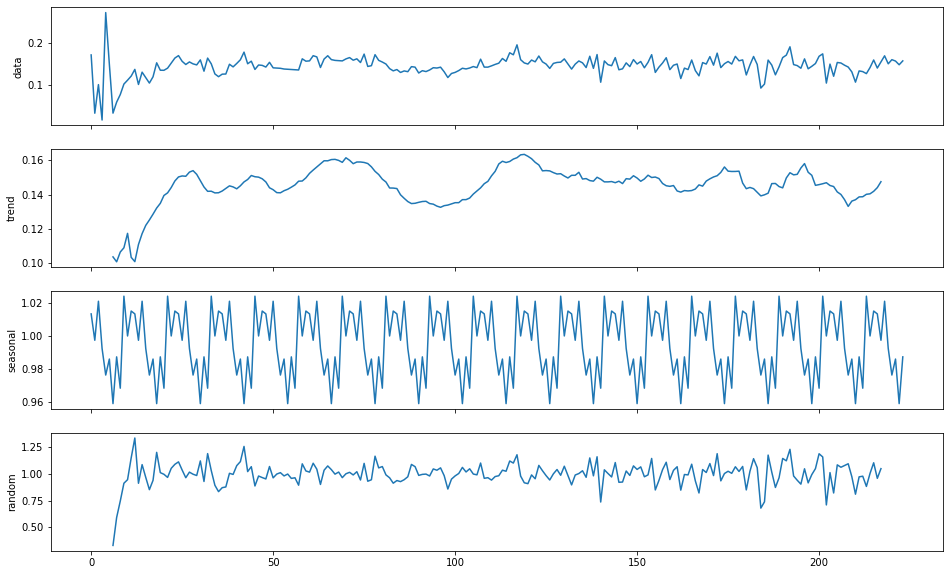

In [14]:
decomposed_d = decompose(ts_d['Positive Sentiment'].values, 'multiplicative', m=12)
decomposed_plot(decomposed_d, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [15]:
comp_ts = pd.read_csv('data/amc_numeric_sents.csv', low_memory=False)

In [16]:
date = []
for i in comp_ts['created_utc']:
    x = int(i)
    date.append(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
comp_ts['date']=date

In [17]:
comp_ts['date'] = pd.to_datetime(comp_ts['date'])
comp_ts.set_index('date', inplace=True)

In [18]:
comp_ts.drop(['cleaned_body','created_utc','Positive Sentiment','Neutral Sentiment','Negative Sentiment'],axis=1,inplace=True)

In [19]:
comp_ts_d = comp_ts.resample('D').mean()
comp_ts_d = comp_ts_d.interpolate()

In [20]:
ts_d = ts_d[ts_d.index.isin(early.index)==True]

In [21]:
comp_ts_d = comp_ts_d[comp_ts_d.index.isin(early.index)==True]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(comp_ts_d)
normalized = scaler.transform(comp_ts_d)
my_list = map(lambda x: x[0], normalized)
comp_ts_d_normalized = pd.Series(my_list)
price_scaler = scaler.fit(prices)
comp_price_normalized = price_scaler.transform(prices)
comp_price_list = map(lambda x: x[0], comp_price_normalized)
comp_price_d_normalized = pd.Series(comp_price_list)

In [22]:
comp_ts_d_normalized.index = comp_ts_d.index
comp_price_d_normalized.index = comp_ts_d.index

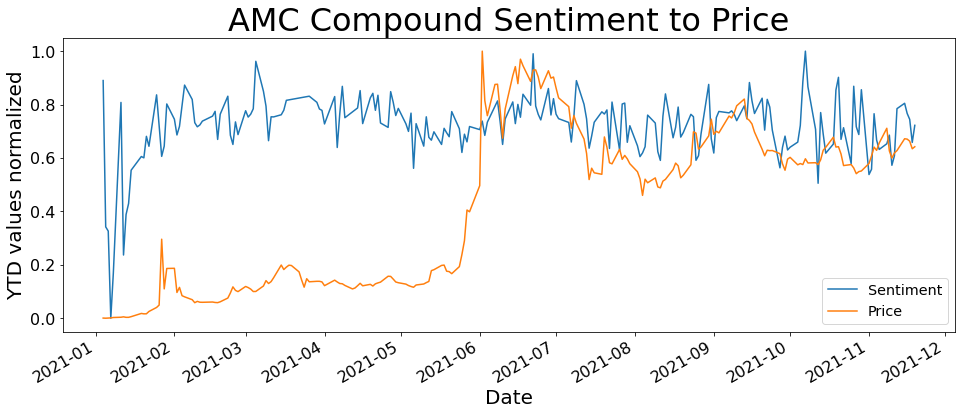

In [24]:
plt.figure(figsize=(16,6))
comp_ts_d_normalized.plot(label='Sentiment')
comp_price_d_normalized.plot(label='Price')
# rollmean_comp_d = comp_ts_d_normalized.rolling(window=7, center=False).mean()
# plt.plot(rollmean_comp_d, color='red', label='Rolling 7-Day Mean')
plt.title('AMC Compound Sentiment to Price', fontsize=32)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date',fontsize=20)
plt.ylabel('YTD values normalized', fontsize=20)
plt.legend(fontsize='x-large');

In [47]:
# rollmean_comp_d = comp_ts_d['Compound Sentiment'].rolling(window=7, center=False).mean()
# rollstd_comp_d = comp_ts_d['Compound Sentiment'].rolling(window=7, center=False).std()
# fig, ax = plt.subplots(figsize=(13, 6))
# ax.plot(comp_ts_d['Compound Sentiment'], color='blue',
#         label='Average Daily Compound Sentiment (-1 to 1)')

# ax.plot(rollmean_comp_d, color='red', label='Rolling 7-Day Mean')

# ax.plot(rollmean_comp_d + rollstd_comp_d, color='black', linestyle='dotted')
# ax.plot(rollmean_comp_d - rollstd_comp_d, color='black', linestyle='dotted')
# ax.legend()
# fig.tight_layout()

In [48]:
adfuller(comp_ts_d['Compound Sentiment'])

(-8.723573653155679,
 3.334810057258709e-14,
 0,
 223,
 {'1%': -3.460018927623594,
  '5%': -2.8745897386146817,
  '10%': -2.57372514086348},
 -782.773518067651)

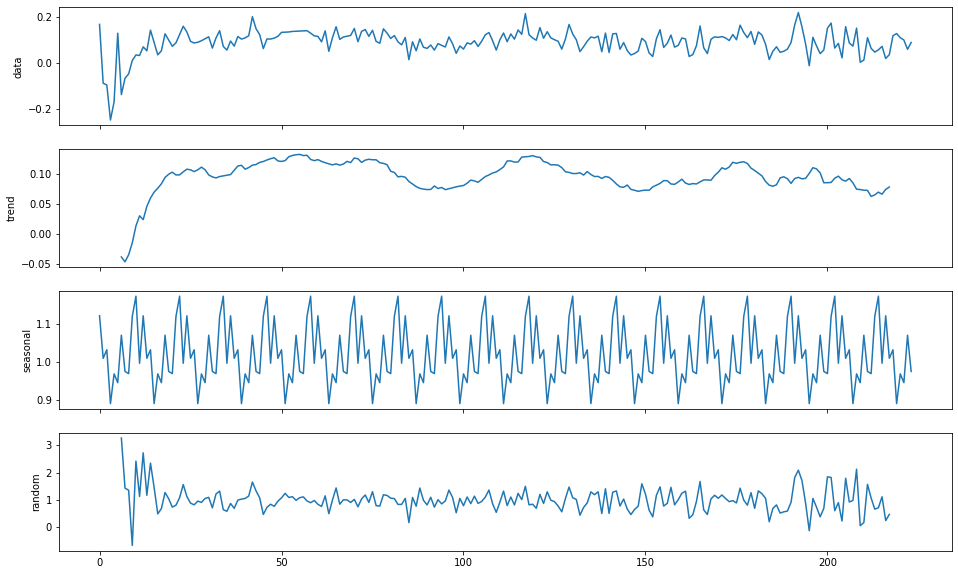

In [49]:
decomposed_comp_d = decompose(comp_ts_d['Compound Sentiment'].values, 'multiplicative', m=12)
decomposed_plot(decomposed_comp_d, figure_kwargs={'figsize': (16, 10)});

### Random Walk model

In [50]:
#https://github.com/Amberlynnyandow/bsc-lecture-material/blob/main/phase_4/time_series_modeling.ipynb

In [51]:
cutoff = round(comp_ts_d.shape[0]*0.8)
cutoff

179

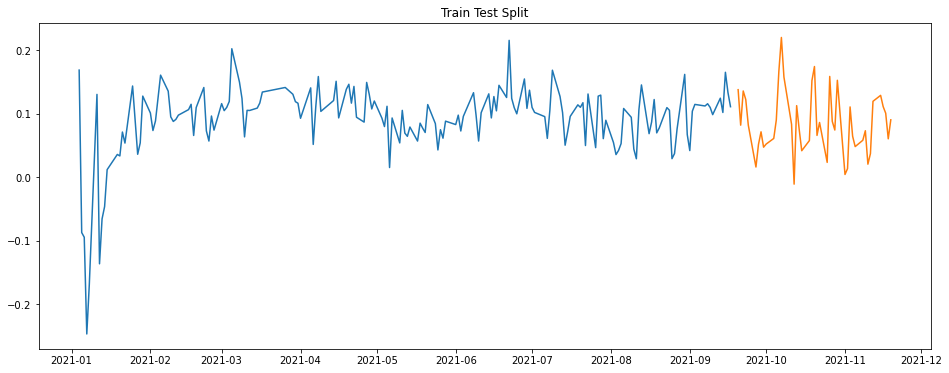

In [52]:
train = comp_ts_d[:cutoff]
test = comp_ts_d[cutoff:]
plt.figure(figsize=(16,6))
plt.plot(train)
plt.plot(test)
plt.title('Train Test Split');

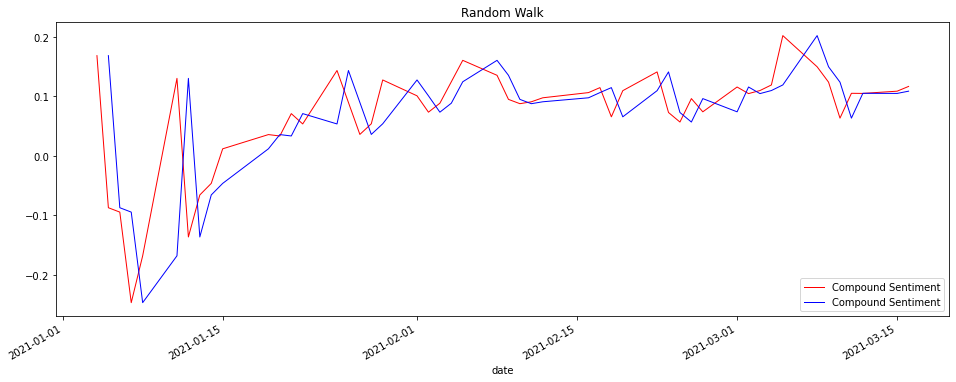

In [53]:
random_walk = train.shift(1)
fig, ax=plt.subplots(figsize=(16,6))
train[0:50].plot(ax=ax,color='red', label='original',linewidth=1.0)
random_walk[0:50].plot(ax=ax,color='blue', label='shifted',linewidth=1.0)
ax.set_title('Random Walk')
ax.legend();

In [54]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(train[1:], random_walk.dropna()))

0.05465680262610326

In [55]:
residuals = random_walk[1:] - train[1:]

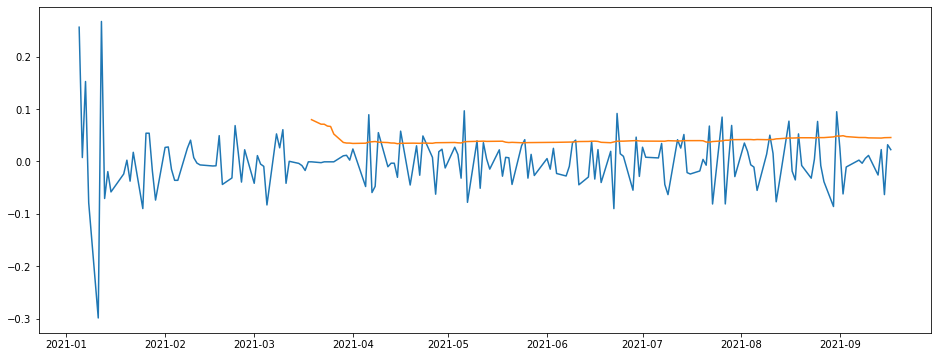

In [56]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

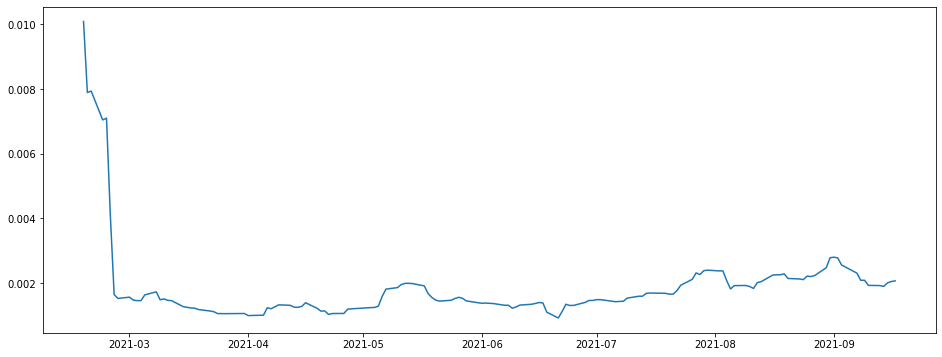

In [57]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(residuals.index, residuals.rolling(30).var());

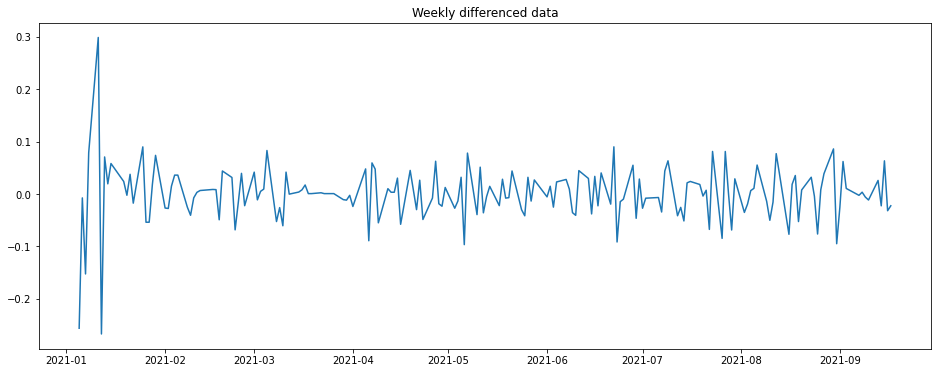

In [58]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(train.diff())
ax.set_title('Weekly differenced data');